In [1]:
# import importlib
# import aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils as tku

# importlib.reload(tku)


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from scipy.stats import linregress



In [3]:
#Load kinematics data
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import load_keypoints_from_csv, find_behavior_videos_folder, integrate_keypoints_with_video_time

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'
# LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717121_2024-06-15_10-00-58/bottom_camera.csv'
# LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717259_2024-06-28_11-17-19/bottom_camera.csv'
# LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717263_2024-07-24_10-40-05/bottom_camera.csv'

keypoint_dfs = load_keypoints_from_csv(LP_csv_path)

session_name = os.path.basename(os.path.dirname(LP_csv_path))
behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718


In [4]:
#tongue kinematics processing and movement annotation
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements_trimnans
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)


In [5]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

nwb = get_nwb_file(session_name)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_licks = annotation.annotate_licks(nwb)

Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [6]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import annotate_trials_in_kinematics, annotate_licks_in_kinematics, assign_movements_to_licks

tongue_segmented = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)
tongue_kinematics = annotate_licks_in_kinematics(tongue_segmented, nwb.df_licks, tolerance=0.01)
nwb.df_licks = assign_movements_to_licks(tongue_kinematics, nwb.df_licks)

In [36]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements

tongue_movements = aggregate_tongue_movements(tongue_kinematics,keypoint_dfs_trimmed)

tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    nwb.df_licks,
    fields=['cue_response', 'rewarded', 'event','timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})


In [8]:
#get model fitting results

print(f'session: {session_name}')
match = re.match(r'behavior_(\d+)_(\d{4}-\d{2}-\d{2})', session_name)
if match:
    subject_id = match.group(1)
    session_date = match.group(2)

print(subject_id)     # '751004'
print(session_date)   # '2024-12-20'

models_df = get_mle_model_fitting(subject_id=subject_id, session_date=session_date)

model_df = models_df[models_df['agent_alias'] == 'QLearning_L2F1_CKfull_softmax']

model_latents = pd.json_normalize(model_df['latent_variables'])


session: behavior_716325_2024-05-31_10-31-14
716325
2024-05-31
Query: {'analysis_spec.analysis_name': 'MLE fitting', 'analysis_spec.analysis_ver': 'first version @ 0.10.0', 'subject_id': '716325', 'session_date': '2024-05-31'}
Found 31 MLE fitting records!
Found 31 successful MLE fitting!


Get latent variables from s3: 100%|██████████| 31/31 [00:00<00:00, 44.07it/s]


In [9]:
def attach_model_latents_to_trials(df_trials, model_latents):
    """
    Attach model latent variables to df_trials for a single session.

    Parameters:
    - df_trials: trial-level DataFrame (from nwb.df_trials)
    - model_latents: DataFrame from pd.json_normalize(model_df['latent_variables'])
                     containing columns like 'q_value', 'choice_kernel', etc.

    Returns:
    - df_trials with added columns: L_prob, R_prob, L_value, R_value, L_kernel, R_kernel, rpe
    """
    df_trials = df_trials.copy()

    # Identify indices where the animal responded (0 = left, 1 = right)
    valid_idx = df_trials[df_trials["animal_response"].isin([0, 1])].index

    # Extract and properly transpose/trim latent variables
    q_values = np.array(model_latents['q_value'].iloc[0], dtype=float)[:, :-1]           # shape: (2, N) -> [L, R]
    ck_values = np.array(model_latents['choice_kernel'].iloc[0], dtype=float)[:, :-1]    # shape: (2, N)
    cp_values = np.array(model_latents['choice_prob'].iloc[0], dtype=float)              # shape: (2, N)
    rpe_values = np.array(model_latents['rpe'].iloc[0], dtype=float)                     # shape: (N,)

    # # Sanity check
    # n_valid = len(valid_idx)
    # assert cp_values.shape[1] == n_valid, "Mismatch in number of valid trials and choice_prob length"
    # assert q_values.shape[1] == n_valid, "Mismatch in number of valid trials and q_value length"
    # assert ck_values.shape[1] == n_valid, "Mismatch in number of valid trials and choice_kernel length"
    # assert len(rpe_values) == n_valid, "Mismatch in number of valid trials and RPE length"

    # Initialize new columns with NA
    for col in ["L_prob", "R_prob", "L_value", "R_value", "L_kernel", "R_kernel", "rpe"]:
        df_trials[col] = np.nan

    # Assign values
    df_trials.loc[valid_idx, "L_prob"] = cp_values[0]
    df_trials.loc[valid_idx, "R_prob"] = cp_values[1]
    df_trials.loc[valid_idx, "L_value"] = q_values[0]
    df_trials.loc[valid_idx, "R_value"] = q_values[1]
    df_trials.loc[valid_idx, "L_kernel"] = ck_values[0]
    df_trials.loc[valid_idx, "R_kernel"] = ck_values[1]
    df_trials.loc[valid_idx, "rpe"] = rpe_values

    # Compute raw Q-value difference: QL - QR
    df_trials['q_diff'] = df_trials['R_value'] - df_trials['L_value']

    # # Compute Q-diff-C (regularized)
    # # Initialize qdiff_c with NaN
    # df_trials['q_diff_c'] = np.nan

    # # For trials where animal_response is 0 or 1, compute qdiff_c accordingly
    # mask = df_trials['animal_response'].isin([0, 1])
    # df_trials.loc[mask, 'q_diff_c'] = np.where(
    #     df_trials.loc[mask, 'animal_response'] == 1,
    #     df_trials.loc[mask, 'R_value'] - df_trials.loc[mask, 'L_value'],
    #     df_trials.loc[mask, 'L_value'] - df_trials.loc[mask, 'R_value']
    # )
    return df_trials


In [37]:
df_trials_with_model = attach_model_latents_to_trials(nwb.df_trials, model_latents)


In [38]:
tongue_movements_with_model = tongue_movements.merge(
    df_trials_with_model[["L_prob", "R_prob", "L_value", "R_value", "L_kernel", "R_kernel", "rpe", "q_diff"]],  # or any other latent variables
    left_on="trial",
    right_index=True,
    how="left"
)

In [39]:
cue_response_movements = tongue_movements_with_model[tongue_movements_with_model['cue_response']==True].copy()

In [40]:
# def plot_kinematics_vs_q(tongue_with_q, x_col, y_col, n_bins=9,
#                          save_figures=False, save_dir="/root/capsule/scratch/figures",
#                          ax=None):
#     """
#     If ax is a length-2 list/array of Axes, plot there.
#     Otherwise create a fresh 1×2 figure.
#     """
#     # Prepare data
#     plot_df = tongue_with_q[[x_col, y_col]].dropna().copy()
#     plot_df.loc[:, 'x_bin'] = pd.cut(plot_df[x_col], bins=n_bins)
#     binned = plot_df.groupby('x_bin', observed=True).agg(
#         x_center=(x_col, 'mean'),
#         y_mean=(y_col, 'mean'),
#         y_sem=(y_col, lambda x: x.std(ddof=1) / len(x)**0.5)
#     ).dropna()

#     # Decide where to plot
#     if ax is None:
#         fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#         own_fig = True
#     else:
#         own_fig = False

#     # Raw scatter
#     ax[0].scatter(plot_df[x_col], plot_df[y_col], alpha=0.1)
#     ax[0].set_xlabel(x_col.replace('_', ' ').title())
#     ax[0].set_ylabel(y_col.replace('_', ' ').title())
#     ax[0].set_title("Raw Scatter")
#     ax[0].grid(True)

#     # Binned mean ± SEM
#     ax[1].errorbar(binned['x_center'], binned['y_mean'], 
#                    yerr=binned['y_sem'], fmt='o-', capsize=4)
#     ax[1].set_xlabel(x_col.replace('_', ' ').title())
#     ax[1].set_ylabel(f"Mean {y_col.replace('_', ' ').title()}")
#     ax[1].set_title("Binned Mean ± SEM")
#     ax[1].grid(True)

#     if own_fig:
#         plt.suptitle(f"{y_col.replace('_', ' ').title()} vs. {x_col.replace('_', ' ').title()}", fontsize=14)
#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         if save_figures:
#             os.makedirs(save_dir, exist_ok=True)
#             fname = f"{y_col}_vs_{x_col}".replace(' ', '_')
#             fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)
#             fig.savefig(os.path.join(save_dir, f"{fname}.svg"), dpi=300)
#         plt.show()

In [41]:
def plot_tongue_trajectories_by_variable(tongue_kinematics, movements, color_var, cmap='coolwarm', alpha=0.7, s=5, ax=None):
    """
    Plot x vs y tongue trajectories from tongue_kinematics, colored by a variable in movements.

    Parameters:
    - tongue_kinematics: pd.DataFrame with ['x', 'y', 'movement_id']
    - movements: pd.DataFrame with 'movement_id' and variable to color by
    - color_var: str, column in movements to color trajectories by
    - cmap: str, colormap name (default: 'coolwarm')
    - alpha: float, transparency
    - s: int, scatter point size
    - ax: matplotlib.axes.Axes object to plot into (optional)
    """
    import matplotlib.pyplot as plt
    from matplotlib import colors
    import numpy as np

    # Create lookup dictionary for movement_id -> color value
    color_values = movements.set_index('movement_id')[color_var]

    # Normalize and get colormap
    norm = colors.Normalize(vmin=color_values.min(), vmax=color_values.max())
    cmap = plt.colormaps.get_cmap(cmap)

    # Use passed-in ax or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        own_fig = True
    else:
        own_fig = False

    for movement_id in movements['movement_id']:
        if movement_id not in color_values:
            continue
        group = tongue_kinematics[tongue_kinematics['movement_id'] == movement_id]
        if group.empty:
            continue
        color_val = color_values[movement_id]
        ax.scatter(group['x'], group['y'], color=cmap(norm(color_val)), alpha=alpha, s=s)

    # Colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(color_var)

    ax.set_xlabel('x position (pix)')
    ax.set_ylabel('y position (pix)')
    ax.set_title(f'Tongue Trajectories Colored by {color_var}')

    if own_fig:
        plt.tight_layout()
        plt.show()

    return ax  # Return ax so it can be reused


In [42]:
def plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=None):
    """
    Plot jaw and spout landmark positions on an existing matplotlib Axes.

    Parameters:
    - jaw_coords: pd.Series or dict with 'x' and 'y' for the jaw position
    - spoutL_coords: pd.Series or dict with 'x' and 'y' for the left spout
    - spoutR_coords: pd.Series or dict with 'x' and 'y' for the right spout
    - ax: matplotlib.axes.Axes object to plot into (optional)
    """
    import matplotlib.pyplot as plt

    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(jaw_coords['x'], jaw_coords['y'], c="black", marker="x", s=100, label="Jaw Position")
    ax.scatter(spoutL_coords['x'], spoutL_coords['y'], c="red", s=100, edgecolors='k', label="Right Spout")
    ax.scatter(spoutR_coords['x'], spoutR_coords['y'], c="blue", s=100, edgecolors='k', label="Left Spout")

    ax.legend()
    return ax


In [43]:
def plot_2d_colored_by_hue(tongue_with_q, x_col, y_col, hue_col,
                            cmap='viridis', alpha=1, save_figures=False,
                            save_dir="figures", ax=None, clim=None):
    """
    Creates a 2D scatter plot of y_col vs. x_col colored by hue_col.

    Parameters:
    - tongue_with_q: pd.DataFrame
    - x_col: str, x-axis variable
    - y_col: str, y-axis variable
    - hue_col: str, variable to color by
    - cmap: str, matplotlib colormap (default 'viridis')
    - alpha: float, point transparency
    - save_figures: bool, whether to save the figure
    - save_dir: str, directory to save figure
    - ax: matplotlib.axes.Axes object to plot into (optional)
    - clim: tuple (vmin, vmax), optional color scale limits

    Returns:
    - ax: The matplotlib Axes object used
    """
    import matplotlib.pyplot as plt
    import os

    # Drop missing values
    plot_df = tongue_with_q[[x_col, y_col, hue_col]].dropna()

    # Create figure/axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        own_fig = True
    else:
        own_fig = False

    # Scatter plot
    sc = ax.scatter(plot_df[x_col], plot_df[y_col], c=plot_df[hue_col],
                    s=10, cmap=cmap, alpha=alpha, edgecolors='none')

    # Set color limits if specified
    if clim is not None:
        sc.set_clim(*clim)

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(hue_col.replace('_', ' ').title())

    # Labels and title
    ax.set_xlabel(x_col.replace('_', ' ').title())
    ax.set_ylabel(y_col.replace('_', ' ').title())
    ax.set_title(f"{y_col.replace('_', ' ').title()} vs. {x_col.replace('_', ' ').title()} Colored by {hue_col.replace('_', ' ').title()}")
    ax.grid(True)

    if save_figures and own_fig:
        os.makedirs(save_dir, exist_ok=True)
        fname = f"{y_col}_vs_{x_col}_colored_by_{hue_col}".replace(' ', '_')
        fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)
        fig.savefig(os.path.join(save_dir, f"{fname}.svg"), dpi=300)

    if own_fig:
        plt.tight_layout()
        plt.show()

    return ax


In [44]:
def plot_kinematics_binned_scatter(
    tongue_with_q, x_col, y_col, n_bins=9,
    save_figures=False, save_dir="/root/capsule/scratch/figures",
    ax=None
):
    """
    Overlays a raw scatter and binned mean ± SEM of y_col vs. x_col on the same Axes.

    Parameters:
    - tongue_with_q: pd.DataFrame
    - x_col: str, x-axis variable name
    - y_col: str, y-axis variable name
    - n_bins: int, number of bins for aggregation
    - save_figures: bool, save the figure
    - save_dir: str, directory to save
    - ax: matplotlib Axes to plot into (creates new if None)
    """
    # Prepare data
    plot_df = tongue_with_q[[x_col, y_col]].dropna().copy()
    # Bin the x values
    plot_df.loc[:, 'x_bin'] = pd.cut(plot_df[x_col], bins=n_bins)

    # Aggregate
    binned = plot_df.groupby('x_bin', observed=True).agg(
        x_center=(x_col, 'mean'),
        y_mean=(y_col, 'mean'),
        y_sem=(y_col, lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    ).dropna()

    # Create axes if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        own_fig = True
    else:
        own_fig = False

    # Raw scatter
    ax.scatter(plot_df[x_col], plot_df[y_col], alpha=0.2, label='Raw data')

    # Binned mean ± SEM
    ax.errorbar(
        binned['x_center'], binned['y_mean'],
        yerr=binned['y_sem'], fmt='o-', capsize=4,
        label=f'Binned mean ± SEM'
    )

    # Labels & legend
    ax.set_xlabel(x_col.replace('_', ' ').title())
    ax.set_ylabel(y_col.replace('_', ' ').title())
    ax.set_title(f"{y_col.replace('_',' ').title()} vs. {x_col.replace('_',' ').title()}")
    ax.grid(True)
    ax.legend()

    # Save or show
    if own_fig:
        plt.tight_layout()
        if save_figures:
            os.makedirs(save_dir, exist_ok=True)
            fname = f"{y_col}_vs_{x_col}".replace(' ', '_')
            fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)
            fig.savefig(os.path.join(save_dir, f"{fname}.svg"), dpi=300)
        plt.show()




In [45]:
# Compute landmark centers once
jaw_coords    = keypoint_dfs_trimmed['jaw'][['x','y']].mean()
spoutL_coords = keypoint_dfs_trimmed['spout_l'][['x','y']].mean()
spoutR_coords = keypoint_dfs_trimmed['spout_r'][['x','y']].mean()
jaw_x, jaw_y  = jaw_coords['x'], jaw_coords['y']

# Compute extra columns
cue = cue_response_movements
cue['q_diff_c'] = np.nan
cue.loc[cue.event=='right_lick_time', 'q_diff_c'] = cue.R_value - cue.L_value
cue.loc[cue.event=='left_lick_time',  'q_diff_c'] = cue.L_value - cue.R_value
cue['max_x_from_jaw_y_distance'] = np.abs(cue.max_x_from_jaw_y - jaw_y)
epsilon = 1e-10
cue['chosen_prob'] = np.where(
    cue.event=='left_lick_time', cue.L_prob,
    np.where(cue.event=='right_lick_time', cue.R_prob, np.nan)
)
cue['chosen_prob'] = np.clip(cue['chosen_prob'], epsilon, 1.0)
cue['log_likelihood'] = np.log(cue['chosen_prob'])

# Compute Euclidean distance from jaw to endpoint
cue['endpoint_distance_from_jaw'] = np.sqrt(
    (cue['endpoint_x'] - jaw_x) ** 2 + 
    (cue['endpoint_y'] - jaw_y) ** 2
)

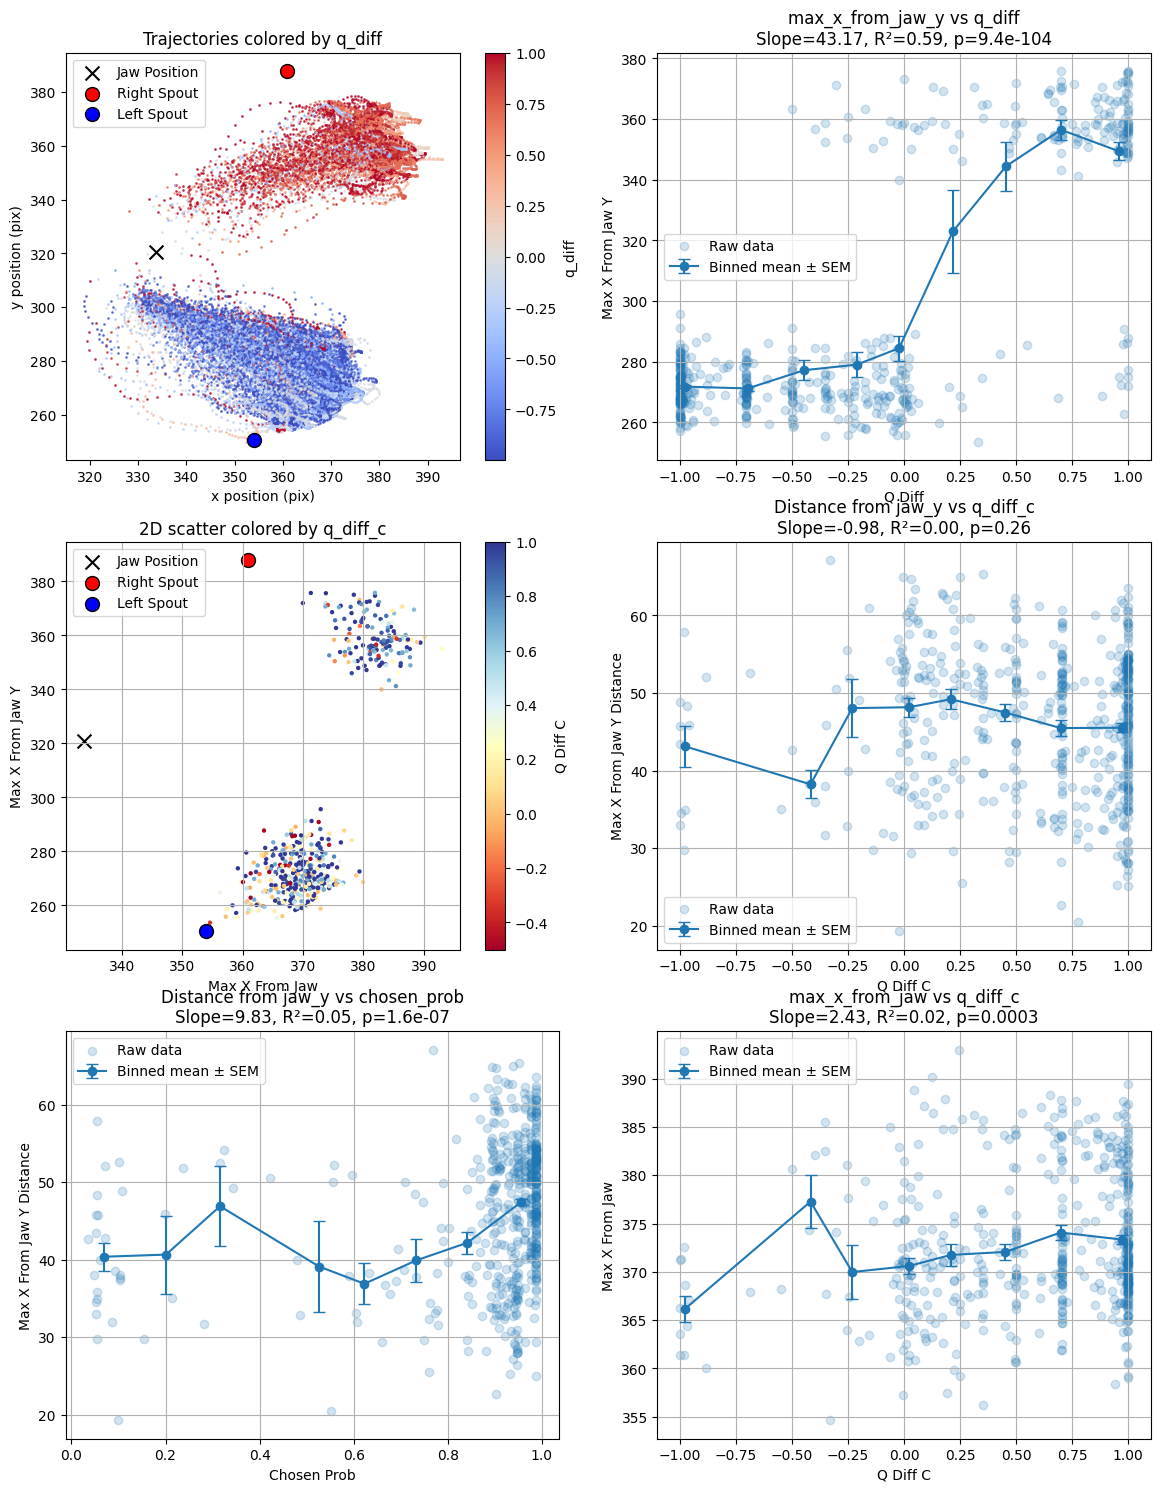

In [46]:

save_fig = False
save_path = f'/root/capsule/scratch/figures/ValueEncoding/{session_name}_CueResponseKinematicsCorrelations.png'


# Regression Pairs and Corresponding Ax Index
regression_pairs = [
    ('q_diff', 'max_x_from_jaw_y', 1),
    ('q_diff_c', 'max_x_from_jaw_y_distance', 3),
    ('q_diff_c', 'max_x_from_jaw', 5),
    ('chosen_prob', 'max_x_from_jaw_y_distance', 4)
]

# Store regression results in a dictionary for easy access
regression_results = {}

for x_col, y_col, ax_idx in regression_pairs:
    x = cue_response_movements[x_col]
    y = cue_response_movements[y_col]
    mask = (~x.isna()) & (~y.isna())
    x_clean = x[mask]
    y_clean = y[mask]

    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    t_stat = slope / std_err

    regression_results[(x_col, y_col)] = {
        "slope": slope, "intercept": intercept, "r2": r_value**2,
        "p": p_value, "t": t_stat, "n": len(x_clean)
    }

# Set up 3×2 grid
fig, axs = plt.subplots(3, 2, figsize=(14, 18))
axs = axs.flatten()

# 1) Trajectories colored by q_diff
plot_tongue_trajectories_by_variable(
    tongue_kinematics, cue, color_var='q_diff', ax=axs[0], s=1
)
plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=axs[0])
axs[0].set_title('Trajectories colored by q_diff')

# 2) Kinematics vs q_diff
plot_kinematics_binned_scatter(cue_response_movements, 'q_diff', 'max_x_from_jaw_y', ax=axs[1])
stats = regression_results[('q_diff', 'max_x_from_jaw_y')]
axs[1].set_title(
    f"max_x_from_jaw_y vs q_diff\n"
    f"Slope={stats['slope']:.2f}, R²={stats['r2']:.2f}, p={stats['p']:.2g}"
)

# 3) 2D scatter colored by q_diff_c
plot_2d_colored_by_hue(cue,
    x_col='max_x_from_jaw', y_col='max_x_from_jaw_y', hue_col='q_diff_c',
    cmap='RdYlBu', ax=axs[2], clim=(-0.5, 1)
)
plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=axs[2])
axs[2].set_title('2D scatter colored by q_diff_c')

# 4) Distance from jaw_y vs q_diff_c
plot_kinematics_binned_scatter(cue_response_movements, 'q_diff_c', 'max_x_from_jaw_y_distance', ax=axs[3])
stats = regression_results[('q_diff_c', 'max_x_from_jaw_y_distance')]
axs[3].set_title(
    f"Distance from jaw_y vs q_diff_c\n"
    f"Slope={stats['slope']:.2f}, R²={stats['r2']:.2f}, p={stats['p']:.2g}"
)

# 5) Distance from jaw_y vs chosen_prob
plot_kinematics_binned_scatter(cue_response_movements, 'chosen_prob', 'max_x_from_jaw_y_distance', ax=axs[4])
stats = regression_results[('chosen_prob', 'max_x_from_jaw_y_distance')]
axs[4].set_title(
    f"Distance from jaw_y vs chosen_prob\n"
    f"Slope={stats['slope']:.2f}, R²={stats['r2']:.2f}, p={stats['p']:.2g}"
)

# 6) max_x_from_jaw vs q_diff_c
plot_kinematics_binned_scatter(cue_response_movements, 'q_diff_c', 'max_x_from_jaw', ax=axs[5])
stats = regression_results[('q_diff_c', 'max_x_from_jaw')]
axs[5].set_title(
    f"max_x_from_jaw vs q_diff_c\n"
    f"Slope={stats['slope']:.2f}, R²={stats['r2']:.2f}, p={stats['p']:.2g}"
)

if save_fig:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Figure saved to: {save_path}")

# plt.tight_layout()
plt.show()


In [47]:


def plot_kinematics_binned_scatter_with_regression(
    tongue_with_q, x_col, y_col, n_bins=9,
    x_range=None,
    save_figures=False, save_dir="/root/capsule/scratch/figures",
    ax=None
):
    """
    Overlays a raw scatter, binned mean ± SEM, and linear regression line on same Axes.

    Parameters:
    - tongue_with_q: pd.DataFrame
    - x_col: str, x-axis variable name
    - y_col: str, y-axis variable name
    - n_bins: int, number of bins for aggregation
    - x_range: tuple (min, max) to limit x-axis values used for plotting and binning
    - save_figures: bool, save the figure
    - save_dir: str, directory to save
    - ax: matplotlib Axes to plot into (creates new if None)

    Returns:
    - regression_results: dict with slope, intercept, r2, p, t, and n
    """
    # Prepare data
    plot_df = tongue_with_q[[x_col, y_col]].dropna().copy()

    # Filter by x_range
    if x_range is not None:
        plot_df = plot_df[(plot_df[x_col] >= x_range[0]) & (plot_df[x_col] <= x_range[1])]

    if plot_df.empty:
        print(f"No data in range {x_range} for {x_col} vs. {y_col}")
        return None

    # Bin the x values
    plot_df.loc[:, 'x_bin'] = pd.cut(plot_df[x_col], bins=n_bins)

    # Aggregate
    binned = plot_df.groupby('x_bin', observed=True).agg(
        x_center=(x_col, 'mean'),
        y_mean=(y_col, 'mean'),
        y_sem=(y_col, lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    ).dropna()

    # Create axes if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        own_fig = True
    else:
        own_fig = False

    # Raw scatter
    ax.scatter(plot_df[x_col], plot_df[y_col], alpha=0.2, label='Raw data')

    # Binned mean ± SEM
    ax.errorbar(
        binned['x_center'], binned['y_mean'],
        yerr=binned['y_sem'], fmt='o-', capsize=4,
        label=f'Binned mean ± SEM'
    )

    # Linear regression on filtered data
    slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_col], plot_df[y_col])
    t_stat = slope / std_err

    # Plot regression line
    x_fit = np.linspace(plot_df[x_col].min(), plot_df[x_col].max(), 200)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, color='black', linestyle='--', label='Linear fit')

    # Labels & legend
    ax.set_xlabel(x_col.replace('_', ' ').title())
    ax.set_ylabel(y_col.replace('_', ' ').title())
    ax.set_title(f"{y_col.replace('_',' ').title()} vs. {x_col.replace('_',' ').title()}")
    ax.grid(True)
    ax.legend()

    # Save or show
    if own_fig:
        plt.tight_layout()
        if save_figures:
            os.makedirs(save_dir, exist_ok=True)
            fname = f"{y_col}_vs_{x_col}".replace(' ', '_')
            fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)
            fig.savefig(os.path.join(save_dir, f"{fname}.svg"), dpi=300)
        plt.show()

    # Return regression stats
    return {
        "slope": slope,
        "intercept": intercept,
        "r2": r_value**2,
        "p": p_value,
        "t": t_stat,
        "n": len(plot_df)
    }


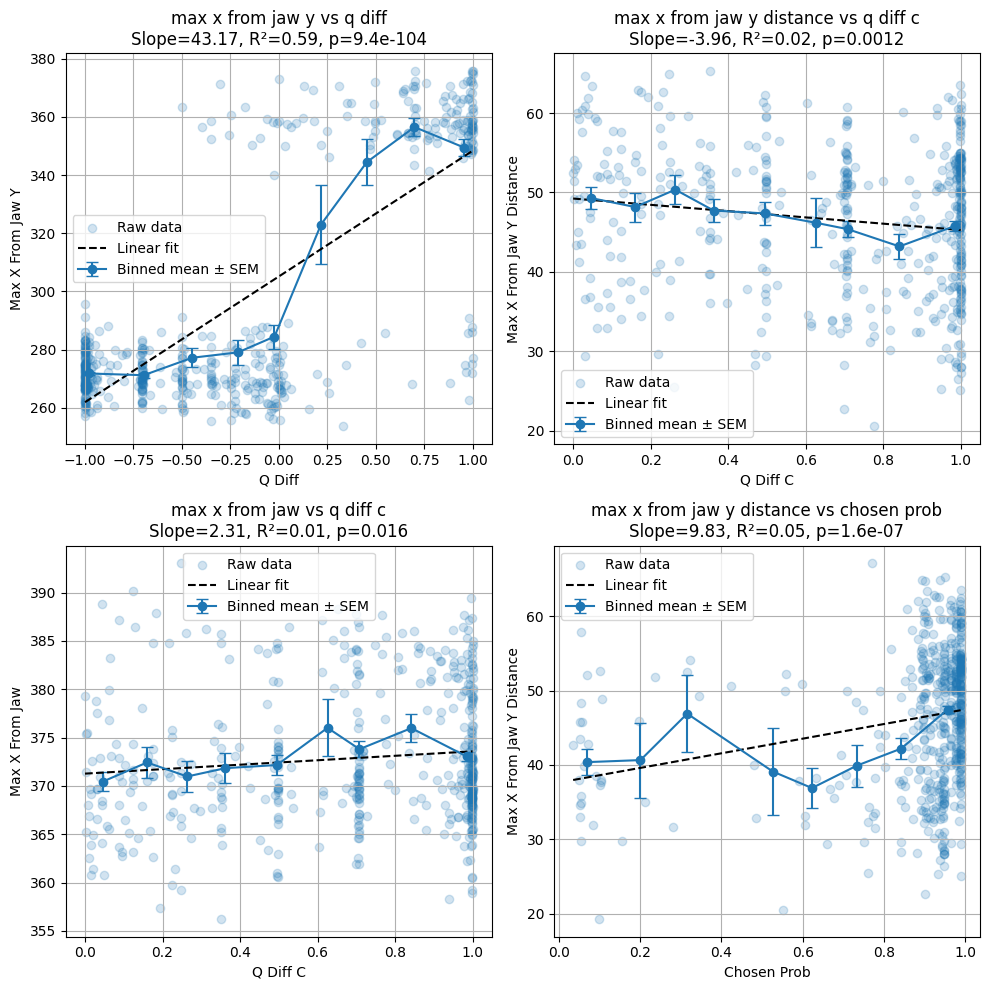

In [48]:
save_path = f'/root/capsule/scratch/figures/ValueEncoding/{session_name}_CueResponseKinematicsCorrelations_limitedrange.png'

# Define regression pairs
regression_pairs = [
    ('q_diff', 'max_x_from_jaw_y'),
    ('q_diff_c', 'max_x_from_jaw_y_distance'),
    ('q_diff_c', 'max_x_from_jaw'),
    ('chosen_prob', 'max_x_from_jaw_y_distance')
]

# Define dynamic x-ranges per variable
x_ranges = {
    'q_diff': (-1, 1),
    'q_diff_c': (0, 1),
    'chosen_prob': (0, 1)
}

# Create 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

# Dictionary to store regression stats
regression_results = {}

# Loop through each pair and subplot axis
for i, (x_col, y_col) in enumerate(regression_pairs):
    ax = axs[i]
    x_range = x_ranges.get(x_col, None)

    result = plot_kinematics_binned_scatter_with_regression(
        tongue_with_q=cue_response_movements,
        x_col=x_col,
        y_col=y_col,
        n_bins=9,
        x_range=x_range,
        ax=ax,
        save_figures=False
    )

    regression_results[(x_col, y_col)] = result

    if result is not None:
        ax.set_title(
            f"{y_col.replace('_',' ')} vs {x_col.replace('_',' ')}\n"
            f"Slope={result['slope']:.2f}, R²={result['r2']:.2f}, p={result['p']:.2g}"
        )

# Clean layout
plt.tight_layout()

if save_fig:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Figure saved to: {save_path}")

plt.show()


In [49]:
no_lick_movements = tongue_movements_with_model.query('has_lick == False')

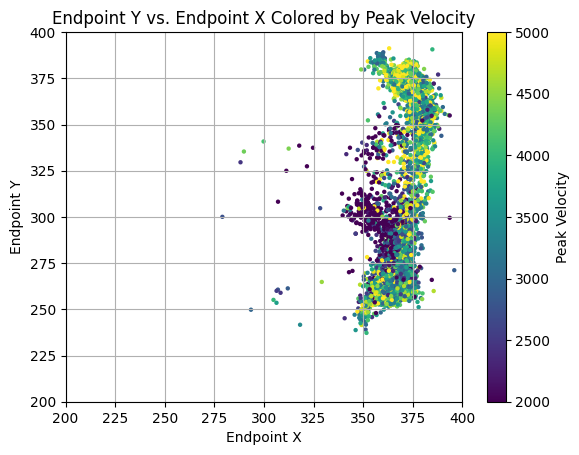

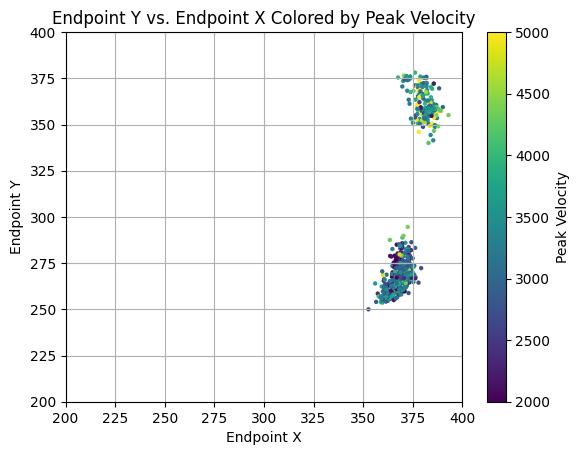

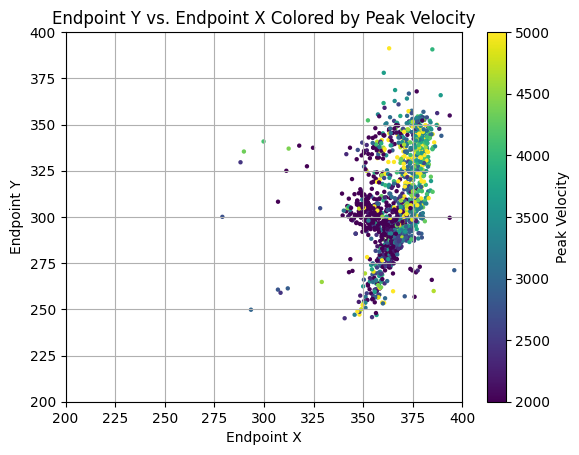

In [50]:
fig, ax = plt.subplots()

plot_2d_colored_by_hue(
    tongue_movements_with_model,
    x_col='endpoint_x',
    y_col='endpoint_y',
    hue_col='peak_velocity',
    clim=(2000, 5000),
    ax=ax  # Assuming your function accepts an 'ax' parameter
)

ax.set_ylim(200, 400)  # Set y-axis limits
ax.set_xlim(200, 400)  # Set y-axis limits

plt.show()

fig, ax = plt.subplots()

plot_2d_colored_by_hue(
    cue_response_movements,
    x_col='endpoint_x',
    y_col='endpoint_y',
    hue_col='peak_velocity',
    clim=(2000, 5000),
    ax=ax  # Assuming your function accepts an 'ax' parameter
)

ax.set_ylim(200, 400)  # Set y-axis limits
ax.set_xlim(200, 400)  # Set y-axis limits

plt.show()


fig, ax = plt.subplots()

plot_2d_colored_by_hue(
    no_lick_movements,
    x_col='endpoint_x',
    y_col='endpoint_y',
    hue_col='peak_velocity',
    clim=(2000, 5000),
    ax=ax  # Assuming your function accepts an 'ax' parameter
)

ax.set_ylim(200, 400)  # Set y-axis limits
ax.set_xlim(200, 400)  # Set y-axis limits

plt.show()

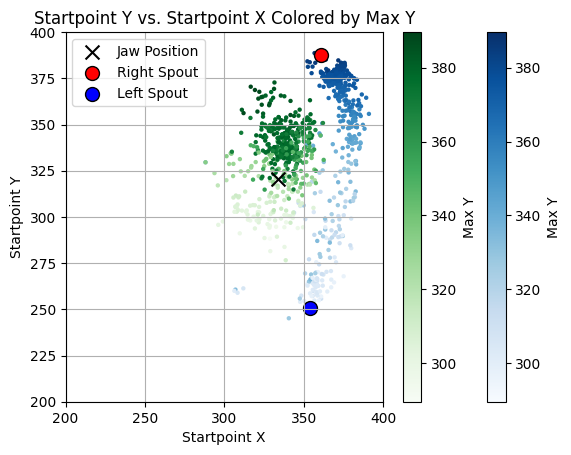

In [51]:

fig, ax = plt.subplots()

plot_2d_colored_by_hue(
    tongue_movements_with_model.iloc[0:500],
    x_col='endpoint_x',
    y_col='endpoint_y',
    hue_col='max_y',
    cmap='Blues',
    ax=ax  # Assuming your function accepts an 'ax' parameter
)

plot_2d_colored_by_hue(
    tongue_movements_with_model.iloc[0:500],
    x_col='startpoint_x',
    y_col='startpoint_y',
    hue_col='max_y',
    cmap='Greens',
    ax=ax  # Assuming your function accepts an 'ax' parameter
)

plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=ax)

ax.set_ylim(200, 400)  # Set y-axis limits
ax.set_xlim(200, 400)  # Set y-axis limits

plt.show()

In [52]:
tongue_movements_with_model.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'max_x_from_jaw',
       'max_x_from_jaw_y', 'max_y_from_jaw', 'max_y_from_jaw_x',
       'max_x_distance', 'max_y_distance', 'excursion_angle_deg',
       'time_to_endpoint', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event', 'lick_time', 'L_prob',
       'R_prob', 'L_value', 'R_value', 'L_kernel', 'R_kernel', 'rpe',
       'q_diff'],
      dtype='object')

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reach_vectors(df, 
                       start_x='startpoint_x', start_y='startpoint_y',
                       end_x='endpoint_x', end_y='endpoint_y',
                       hue_col=None, cmap='viridis', alpha=0.7,
                       colorbar=True, ax=None, title=None,
                       show_points=True, clim=None):
    """
    Plots reach vectors from start to end, optionally colored by a variable.

    Parameters:
    - df: DataFrame with movement data
    - start_x, start_y: column names for start coordinates
    - end_x, end_y: column names for end coordinates
    - hue_col: variable to color by (optional)
    - cmap: colormap
    - alpha: line transparency
    - colorbar: whether to show colorbar
    - ax: matplotlib axis (optional)
    - title: optional plot title
    - show_points: whether to plot start/end points
    - clim: optional (vmin, vmax) for color scaling
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    plot_df = df[[start_x, start_y, end_x, end_y] + ([hue_col] if hue_col else [])].dropna()

    # Get color values
    if hue_col:
        values = plot_df[hue_col].values
        norm = plt.Normalize(vmin=clim[0], vmax=clim[1]) if clim else None
        cmap_obj = plt.colormaps.get_cmap(cmap)
        colors = cmap_obj(norm(values) if norm else values)
    else:
        colors = ['gray'] * len(plot_df)

    # Draw reach vectors
    for i, row in plot_df.iterrows():
        ax.plot([row[start_x], row[end_x]], 
                [row[start_y], row[end_y]],
                color=colors[i], alpha=alpha)

    # Optionally plot start/end points
    if show_points:
        ax.scatter(plot_df[start_x], plot_df[start_y], color='green', s=10, label='Start', alpha=0.6)
        ax.scatter(plot_df[end_x], plot_df[end_y], color='blue', s=10, label='End', alpha=0.6)

    # Axis labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Start to End Reach Vectors")

    ax.grid(True)

    if hue_col and colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm if norm else None)
        sm.set_array(values)
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label(hue_col.replace("_", " ").title())

    ax.legend()
    return ax


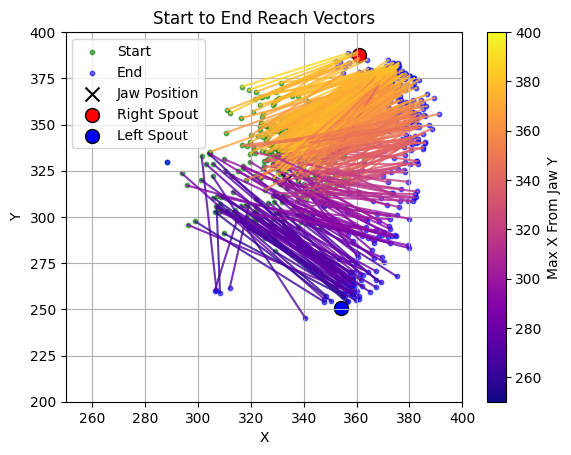

In [54]:
# Example usage
fig, ax = plt.subplots()
plot_reach_vectors(
    tongue_movements_with_model.iloc[0:500],
    hue_col='max_x_from_jaw_y', cmap='plasma', ax=ax,
    clim=(250, 400), alpha=0.8, show_points=True
)
plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=ax)

ax.set_xlim(250, 400)
ax.set_ylim(200, 400)
plt.show()


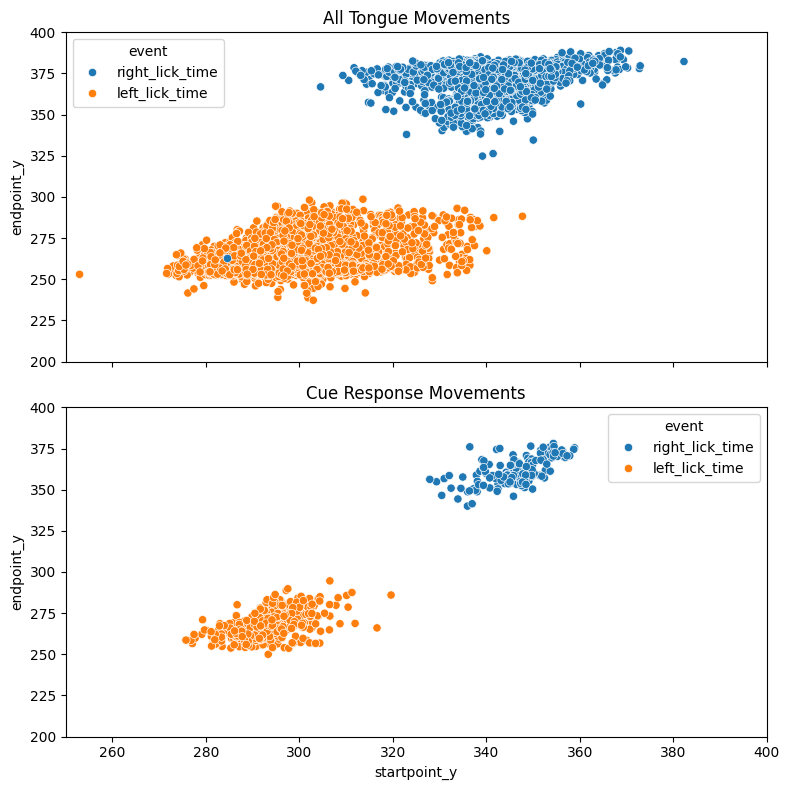

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create two subplots
fig, ax = plt.subplots(2, 1, figsize = (8,8), sharex=True)

# Plot on the first subplot (ax[0])

sns.scatterplot(
    data=tongue_movements_with_model,
    x='startpoint_y', y='endpoint_y',
    hue='event', hue_order=['right_lick_time', 'left_lick_time'],
    ax=ax[0]
)
ax[0].set_xlim(250, 400)
ax[0].set_ylim(200, 400)
ax[0].set_title('All Tongue Movements')

# Plot on the second subplot (ax[1])
sns.scatterplot(
    data=cue_response_movements,
    x='startpoint_y', y='endpoint_y',
    hue='event', hue_order=['right_lick_time', 'left_lick_time'],
    ax=ax[1]
)
ax[1].set_xlim(250, 400)
ax[1].set_ylim(200, 400)
ax[1].set_title('Cue Response Movements')

# Adjust layout
plt.tight_layout()
plt.show()


<Axes: xlabel='startpoint_y', ylabel='endpoint_y'>

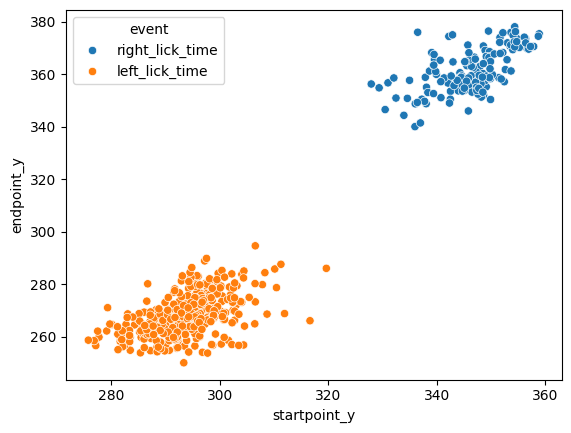

In [56]:
fig, ax = plt.subplots()
sns.scatterplot(data=cue_response_movements,x='startpoint_y',y='endpoint_y',hue='event',hue_order=['right_lick_time','left_lick_time'])


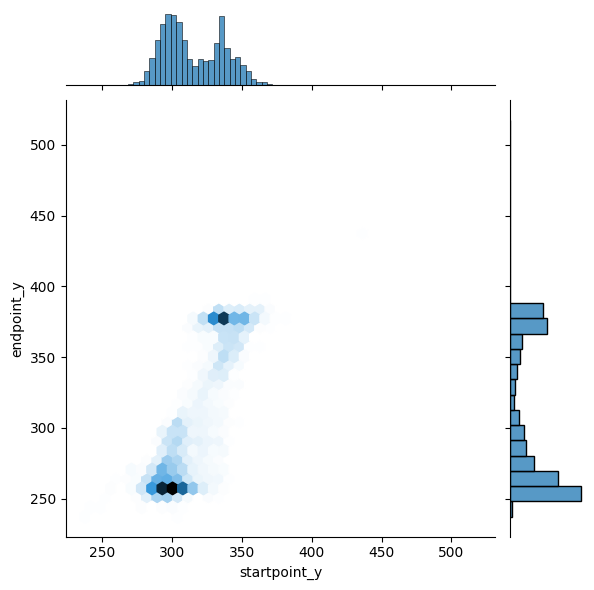

In [57]:
import seaborn as sns
sns.jointplot(data=tongue_movements_with_model, 
              x='startpoint_y', y='endpoint_y', kind='hex')


In [58]:
from scipy.stats import pearsonr

sx = tongue_movements_with_model['startpoint_y']
ex = tongue_movements_with_model['endpoint_y']
mask = sx.notna() & ex.notna()

r, p = pearsonr(sx[mask], ex[mask])
print(f"Pearson r = {r:.3f}, p = {p:.3e}")


X = tongue_movements_with_model[['startpoint_y']].dropna().values
y = tongue_movements_with_model['endpoint_y'].dropna().values

from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X, y, n_neighbors=5)
print(f"Mutual information ≈ {mi[0]:.3f} bits")

Pearson r = 0.855, p = 0.000e+00
Mutual information ≈ 0.676 bits


In [72]:
import pandas as pd

def annotate_movement_timing(tongue_movements: pd.DataFrame,
                             df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate each movement with trial-relative metrics and
    invalidate any movement that spans a go-cue boundary.

    New columns (nullable):
      • movement_number_in_trial     Int64  
      • cue_response_movement_number Int64  
      • movement_before_cue_response boolean  
      • movement_latency_from_go     Float64  

    Pre-trial or spanning movements keep all-new as NA.
    """
    # 1) Sanity checks
    if 'cue_response' not in tongue_movements:
        raise ValueError("Missing 'cue_response'. Run add_lick_metadata_to_movements().")
    for col in ('trial','start_time','end_time'):
        if col not in tongue_movements:
            raise ValueError(f"Missing '{col}' in tongue_movements")
    if not {'trial','goCue_start_time_in_session'}.issubset(df_trials):
        raise ValueError("df_trials must contain 'trial' and 'goCue_start_time_in_session'")

    # 2) Null-out any movement spanning a go-cue
    df = tongue_movements.copy()
    go_times = df_trials['goCue_start_time_in_session']
    # unique movements only
    uniq = df[['movement_id','start_time','end_time']].drop_duplicates()
    bad = {
        m for m, s, e in uniq.itertuples(index=False)
        if ((go_times > s) & (go_times < e)).any()
    }
    df.loc[df['movement_id'].isin(bad), 'trial'] = pd.NA

    # 3) Map go-cue back onto each movement row
    go_map = df_trials.set_index('trial')['goCue_start_time_in_session']
    df['goCue_start_time_in_session'] = df['trial'].map(go_map)

    # 4) Ensure ordering by (trial, start_time)
    valid = df['trial'].dropna()
    if not valid.is_monotonic_increasing:
        raise ValueError("Trials not in ascending order")
    ok = (
        df.dropna(subset=['trial'])
          .groupby('trial', sort=False)['start_time']
          .apply(lambda x: x.dropna().is_monotonic_increasing)
          .all()
    )
    if not ok:
        raise ValueError("start_time not monotonic within trial")

    # 5) Number & annotate
    df['movement_number_in_trial'] = df.groupby('trial').cumcount() + 1
    df['cue_response_movement_number'] = (
        df.groupby('trial')['movement_number_in_trial']
          .transform(lambda m: m.where(df.loc[m.index,'cue_response']).max())
    )
    df['movement_before_cue_response'] = (
        df['movement_number_in_trial'] < df['cue_response_movement_number']
    )
    df['movement_latency_from_go'] = (
        df['start_time'] - df['goCue_start_time_in_session']
    ).where(df['start_time'] >= df['goCue_start_time_in_session'])

    # 6) Cast to nullable dtypes
    df = df.astype({
        'movement_number_in_trial':       'Int64',
        'cue_response_movement_number':   'Int64',
        'movement_before_cue_response':   'boolean',
        'movement_latency_from_go':       'Float64',
    })

    # 7) Blank out all-new for any row without a valid trial
    is_pre = df['trial'].isna()
    df.loc[is_pre, [
        'movement_number_in_trial',
        'cue_response_movement_number',
        'movement_before_cue_response',
        'movement_latency_from_go'
    ]] = pd.NA

    return df


In [73]:
tongue_movements = annotate_movement_timing(tongue_movements, nwb.df_trials)


In [ ]:
#figure 1: lick latency vs movement latency
#side by side plot with histograms

In [63]:
all(tongue_movements['movement_latency_from_go'].dropna().values) > 0

True

In [113]:

def plot_latency_distributions(df: pd.DataFrame):
    """
    Plot normalized latency distributions:
      • Lick latency (cue-response movements)
      • First movement latency
      • Second movement latency (if present)
    """

    # --- Lick latency ---
    lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

    # --- First & second movement latency ---
    moves = (
        df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
        .dropna(subset=['movement_latency_from_go'])
        .sort_values(['trial', 'movement_number_in_trial'])
    )

    first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
    second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.arange(0, 1.05, 0.02)

    ax.hist(lick_lat, bins=bins, density=True, alpha=0.8, label='Lick latency')
    ax.hist(first_move, bins=bins, density=True, alpha=0.2, label='First move latency')
    ax.hist(second_move, bins=bins, density=True, alpha=0.2, label='Second move latency')

    ax.set(
        title="Latency Distributions: Licks vs Movements",
        xlabel="time from go cue (s)",
        ylabel="Proportion of Trials"
    )
    ax.legend()
    fig.tight_layout()
    return fig

In [114]:

def plot_pre_lick_stats(df: pd.DataFrame):
    """
    Plot stats on pre-lick (non-lick) movements (Fig 2 from before).
    Assumes no duplicate cue_response per trial.
    """

    # --- Valid trials & pre-lick movements ---
    valid_trials = df.loc[df['cue_response'] == True, 'trial'].values
    df_valid = df.loc[df['trial'].isin(valid_trials)].copy()
    pre_lick = df_valid.loc[
        df_valid['movement_number_in_trial'] < df_valid['cue_response_movement_number']
    ].copy()

    cue_angles = df.loc[df['cue_response'] == True, ['trial', 'excursion_angle_deg']]
    cue_angles = cue_angles.set_index('trial')['excursion_angle_deg']
    pre_lick['cue_angle'] = pre_lick['trial'].map(cue_angles)

    # --- Panels ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    total_trials = len(valid_trials)
    trials_with_pre = pre_lick['trial'].nunique()

    # a) Fraction of trials with pre-lick movements
    axes[0,0].bar(['with_pre','without_pre'],
                  [trials_with_pre/total_trials, 1 - trials_with_pre/total_trials])
    axes[0,0].set(title="Trials w/ Pre-Lick Movements", ylabel="Fraction")

    # b) Count per trial
    counts = pre_lick.groupby('trial').size()
    axes[0,1].hist(counts, bins=range(1, counts.max()+2))
    axes[0,1].set(title="Pre-Lick Count per Trial", xlabel="Count", ylabel="Trials")

    # c) Distance
    pre_lick['distance'] = ((pre_lick['endpoint_x'] - pre_lick['startpoint_x'])**2 +
                            (pre_lick['endpoint_y'] - pre_lick['startpoint_y'])**2)**0.5
    axes[1,0].hist(pre_lick['distance'], bins=30)
    axes[1,0].set(title="Pre-Lick Movement Distance", xlabel="Euclidean dist", ylabel="Count")

    # d) Angle alignment
    axes[1,1].scatter(pre_lick['excursion_angle_deg'], pre_lick['cue_angle'])
    axes[1,1].set(title="Angle: Pre-Lick vs Cue", xlabel="Pre-Lick (deg)", ylabel="Cue (deg)")

    fig.tight_layout()
    return fig


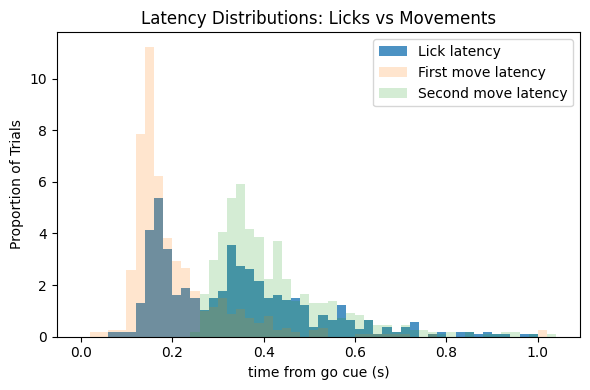

In [115]:
fig1 = plot_latency_distributions(tongue_movements)



In [117]:
tongue_movements.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'max_x_from_jaw',
       'max_x_from_jaw_y', 'max_y_from_jaw', 'max_y_from_jaw_x',
       'max_x_distance', 'max_y_distance', 'excursion_angle_deg',
       'time_to_endpoint', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event', 'lick_time',
       'goCue_start_time_in_session', 'movement_number_in_trial',
       'cue_response_movement_number', 'movement_before_cue_response',
       'movement_latency_from_go', 'lick_latency'],
      dtype='object')

In [ ]:
tongue_movements_one_prelickmove = tongue_movements.query('')

In [69]:
df = tongue_movements.copy()
# 1) Grab only the cue_response rows
cue_df = df[df['cue_response'] == True].copy()

# 2) Find trials that appear more than once
dup_trials = cue_df['trial'].duplicated(keep=False)

# 3) Display all offending rows
duplicates = cue_df.loc[dup_trials, 
                        ['trial','start_time','lick_time','goCue_start_time_in_session']]
print(duplicates)


      trial   start_time    lick_time  goCue_start_time_in_session
6416  495.0  4590.834752  4590.845760                  4590.524448
6434  495.0  4598.130752  4598.190816                  4590.524448


In [70]:
nwb.df_licks[nwb.df_licks['trial'] == 495]

,timestamps,data,event,raw_timestamps,trial,pre_ili,post_ili,bout_start,bout_end,bout_number,...,cue_response,bout_cue_response,intertrial_choice,bout_intertrial_choice,cue_switch,iti_switch,bout_cue_switch,bout_iti_switch,within_session,nearest_movement_id
5154,4590.845760,1.0,left_lick_time,3.897562e+06,495,1.379328,0.200480,True,False,1095,...,True,True,False,False,False,False,False,False,True,6417
5155,4591.046240,1.0,left_lick_time,3.897562e+06,495,0.200480,0.213824,False,False,1095,...,False,True,False,False,False,False,False,False,True,6418
5156,4591.260064,1.0,left_lick_time,3.897562e+06,495,0.213824,0.182592,False,False,1095,...,False,True,False,False,False,False,False,False,True,6419
5157,4591.442656,1.0,left_lick_time,3.897562e+06,495,0.182592,0.172736,False,False,1095,...,False,True,False,False,False,False,False,False,True,6420
5158,4591.615392,1.0,left_lick_time,3.897562e+06,495,0.172736,0.161632,False,False,1095,...,False,True,False,False,False,False,False,False,True,6421
5159,4591.777024,1.0,left_lick_time,3.897563e+06,495,0.161632,0.182944,False,False,1095,...,False,True,False,False,False,False,False,False,True,6422
5160,4591.959968,1.0,left_lick_time,3.897563e+06,495,0.182944,0.182912,False,False,1095,...,False,True,False,False,False,False,False,False,True,6423
5161,4592.142880,1.0,left_lick_time,3.897563e+06,495,0.182912,0.158112,False,False,1095,...,False,True,False,False,False,False,False,False,True,6424
5162,4592.300992,1.0,left_lick_time,3.897563e+06,495,0.158112,0.184032,False,False,1095,...,False,True,False,False,False,False,False,False,True,6425
5163,4592.485024,1.0,left_lick_time,3.897563e+06,495,0.184032,0.245280,False,False,1095,...,False,True,False,False,False,False,False,False,True,6426


In [71]:
tongue_movements[tongue_movements['trial']==495]

,movement_id,start_time,end_time,duration,min_x,max_x,min_y,max_y,min_xv,max_xv,...,trial,cue_response,rewarded,event,lick_time,goCue_start_time_in_session,movement_number_in_trial,cue_response_movement_number,movement_before_cue_response,movement_latency_from_go
6416,6417,4590.834752,4590.920736,0.085984,333.044323,366.050592,260.538716,302.450949,-3608.773364,1492.559497,...,495.0,True,False,left_lick_time,4590.845760,4590.524448,1,19,True,0.310304
6417,6418,4591.016736,4591.120736,0.104000,331.806486,369.573116,275.803534,306.263443,-3257.643661,1377.896076,...,495.0,False,True,left_lick_time,4591.046240,4590.524448,2,19,True,0.492288
6418,6419,4591.252736,4591.334752,0.082016,325.784345,364.257941,266.941214,306.918540,-4080.207999,2265.469066,...,495.0,False,False,left_lick_time,4591.260064,4590.524448,3,19,True,0.728288
6419,6420,4591.408736,4591.486752,0.078016,320.518741,360.219532,258.497060,303.478907,-4862.848230,1555.029765,...,495.0,False,False,left_lick_time,4591.442656,4590.524448,4,19,True,0.884288
6420,6421,4591.564736,4591.660736,0.096000,325.126731,360.980089,257.126918,313.759185,-4213.104379,1446.894783,...,495.0,False,False,left_lick_time,4591.615392,4590.524448,5,19,True,1.040288
6421,6422,4591.744736,4591.836736,0.092000,333.068259,363.519840,255.689086,305.298096,-3422.442561,1196.509605,...,495.0,False,False,left_lick_time,4591.777024,4590.524448,6,19,True,1.220288
6422,6423,4591.932736,4592.020736,0.088000,338.863752,362.750688,257.757944,303.081739,-3168.424497,842.957854,...,495.0,False,False,left_lick_time,4591.959968,4590.524448,7,19,True,1.408288
6423,6424,4592.118752,4592.202752,0.084000,338.866591,368.103796,264.275878,303.933110,-3110.206200,819.686722,...,495.0,False,False,left_lick_time,4592.142880,4590.524448,8,19,True,1.594304
6424,6425,4592.288736,4592.376736,0.088000,342.247394,369.812166,257.478190,292.932405,-3448.616443,1447.248315,...,495.0,False,False,left_lick_time,4592.300992,4590.524448,9,19,True,1.764288
6425,6426,4592.476736,4592.562752,0.086016,339.457366,372.681275,257.806333,296.669706,-3686.279597,964.516244,...,495.0,False,False,left_lick_time,4592.485024,4590.524448,10,19,True,1.952288


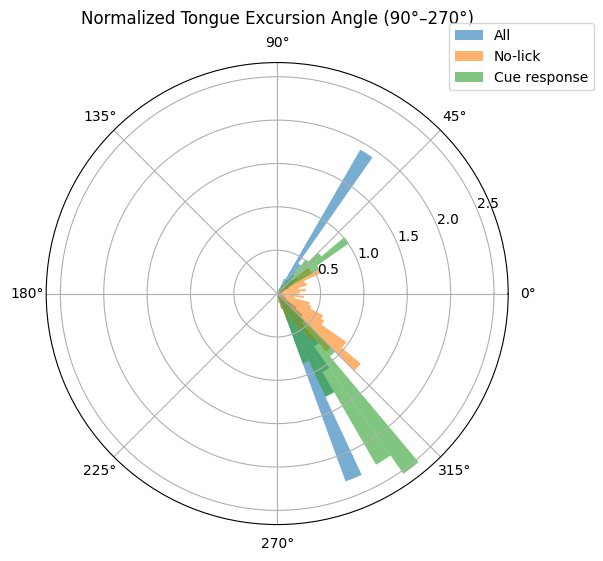

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Convert angles to radians
angles_rad_all = np.deg2rad(tongue_movements_with_model['excursion_angle_deg'])
angles_rad_nolick = np.deg2rad(no_lick_movements['excursion_angle_deg'])
angles_rad_cue = np.deg2rad(cue_response_movements['excursion_angle_deg'])

# Create custom bins from 90° to 270° in 10° increments
bin_edges_deg = np.arange(-90, 90, 5)
bin_edges_rad = np.deg2rad(bin_edges_deg)

# Polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Normalized histograms with custom bins
ax.hist(angles_rad_all, bins=bin_edges_rad, alpha=0.6, label='All', density=True)
ax.hist(angles_rad_nolick, bins=bin_edges_rad, alpha=0.6, label='No-lick', density=True)
ax.hist(angles_rad_cue, bins=bin_edges_rad, alpha=0.6, label='Cue response', density=True)

ax.set_title('Normalized Tongue Excursion Angle (90°–270°)', va='bottom')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()



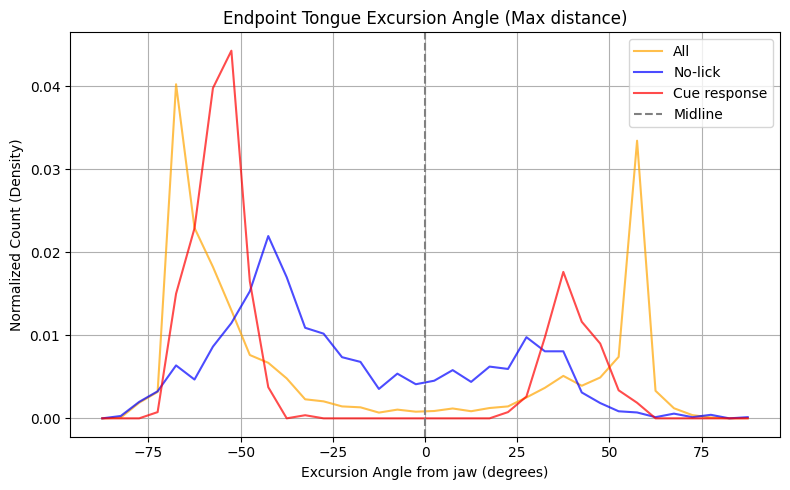

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Convert angle data to degrees instead of radians
angles_deg_all = tongue_movements_with_model['excursion_angle_deg']
angles_deg_nolick = no_lick_movements['excursion_angle_deg']
angles_deg_cue = cue_response_movements['excursion_angle_deg']

# Define bins: from -90° to 90° in 5° increments
bin_edges = np.arange(-90, 95, 5)  # 95 to include 90 as right edge
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Compute normalized histograms (density=True gives PDF)
hist_all, _ = np.histogram(angles_deg_all, bins=bin_edges, density=True)
hist_nolick, _ = np.histogram(angles_deg_nolick, bins=bin_edges, density=True)
hist_cue, _ = np.histogram(angles_deg_cue, bins=bin_edges, density=True)

# Plot in Cartesian (Euclidean) space
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, hist_all, label='All', color='orange', alpha=0.7)
plt.plot(bin_centers, hist_nolick, label='No-lick', color='blue', alpha=0.7)
plt.plot(bin_centers, hist_cue, label='Cue response', color='red', alpha=0.7)

plt.xlabel('Excursion Angle from jaw (degrees)')
plt.ylabel('Normalized Count (Density)')
plt.title('Endpoint Tongue Excursion Angle (Max distance)')
plt.axvline(0, color='gray', linestyle='--', label='Midline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


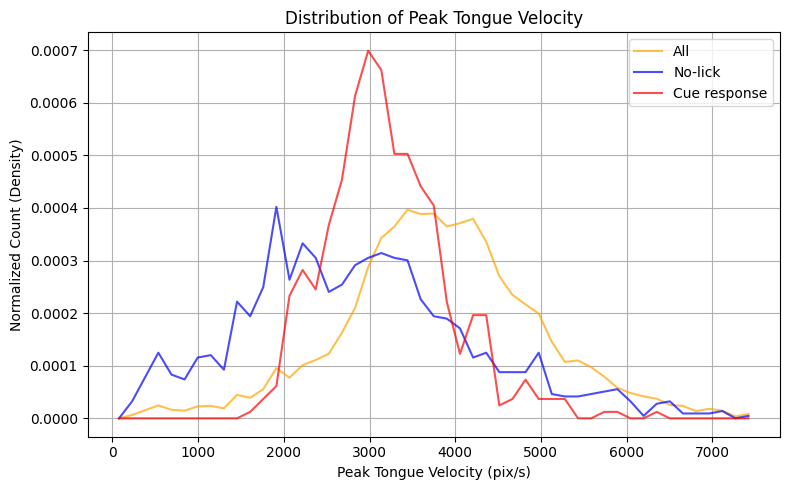

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Get peak velocity data from each group
vel_all = tongue_movements_with_model['peak_velocity']
vel_nolick = no_lick_movements['peak_velocity']
vel_cue = cue_response_movements['peak_velocity']

# Define velocity bins — adjust range if needed
bin_edges = np.linspace(0, np.percentile(vel_all, 99), 50)  # Up to ~99th percentile to avoid long tails
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Compute normalized histograms (density=True gives probability density)
hist_all, _ = np.histogram(vel_all, bins=bin_edges, density=True)
hist_nolick, _ = np.histogram(vel_nolick, bins=bin_edges, density=True)
hist_cue, _ = np.histogram(vel_cue, bins=bin_edges, density=True)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, hist_all, label='All', color='orange', alpha=0.7)
plt.plot(bin_centers, hist_nolick, label='No-lick', color='blue', alpha=0.7)
plt.plot(bin_centers, hist_cue, label='Cue response', color='red', alpha=0.7)

plt.xlabel('Peak Tongue Velocity (pix/s)')  # Change units if needed
plt.ylabel('Normalized Count (Density)')
plt.title('Distribution of Peak Tongue Velocity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


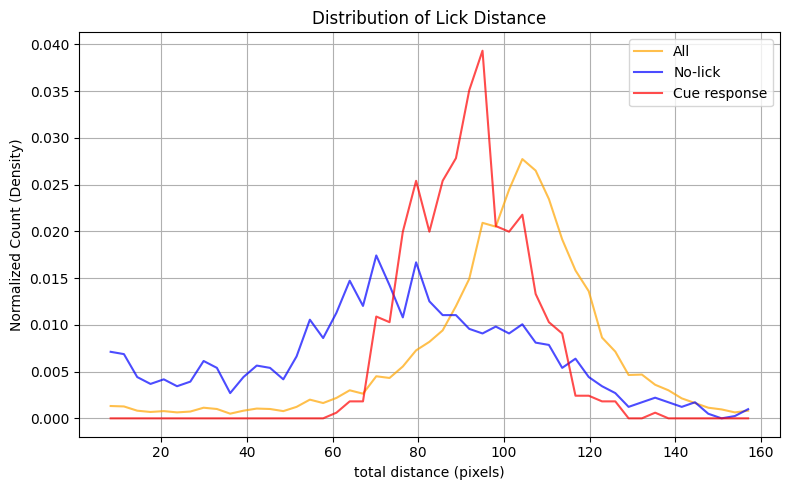

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def clean_data(arr):
    return arr[~np.isnan(arr)]

# Clean NaNs
dist_all = clean_data(tongue_movements_with_model['total_distance'])
dist_nolick = clean_data(no_lick_movements['total_distance'])
dist_cue = clean_data(cue_response_movements['total_distance'])

# Define velocity bins — adjust range if needed
bin_edges = np.linspace(np.percentile(dist_all, 1), np.percentile(dist_all, 99), 50)  # Up to ~99th percentile to avoid long tails
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Compute normalized histograms (density=True gives probability density)
hist_all, _ = np.histogram(dist_all, bins=bin_edges, density=True)
hist_nolick, _ = np.histogram(dist_nolick, bins=bin_edges, density=True)
hist_cue, _ = np.histogram(dist_cue, bins=bin_edges, density=True)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, hist_all, label='All', color='orange', alpha=0.7)
plt.plot(bin_centers, hist_nolick, label='No-lick', color='blue', alpha=0.7)
plt.plot(bin_centers, hist_cue, label='Cue response', color='red', alpha=0.7)

plt.xlabel('total distance (pixels)')  # Change units if needed
plt.ylabel('Normalized Count (Density)')
plt.title('Distribution of Lick Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
tongue_movements_with_model.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'endpoint_x',
       'endpoint_y', 'max_x_from_jaw', 'max_x_from_jaw_y', 'max_y_from_jaw',
       'max_y_from_jaw_x', 'max_x_distance', 'max_y_distance',
       'excursion_angle_deg', 'time_to_endpoint', 'has_lick',
       'first_lick_index', 'lick_count', 'trial', 'cue_response', 'rewarded',
       'event', 'L_prob', 'R_prob', 'L_value', 'R_value', 'L_kernel',
       'R_kernel', 'rpe', 'q_diff'],
      dtype='object')

In [ ]:
#now let's get trials with a cue response and ask whether movement happened first

In [18]:
tongue

In [28]:
def generate_event_times(df, time_col, trial_col, filters=None, cue_times=None):
    """
    Extracts a single event time per trial based on filtering and trial structure.

    Parameters:
        df (DataFrame): Source dataframe containing time data.
        time_col (str): Name of the column with event timestamps.
        trial_col (str): Column indicating trial identity.
        filters (dict): Optional filters. 
                        Special keys include 'cue_response', 'min_after_cue', 'nth'.
        cue_times (dict): Dict of trial -> go cue time, used for filtering.

    Returns:
        dict: trial_id -> event_time
    """
    times = {}
    
    nth = None  # default: take first movement (or first time)

    if filters:
        nth = filters.get('nth', None)

    for tr in df[trial_col].unique():
        sub = df[df[trial_col] == tr].copy()

        # Apply filters
        if filters:
            for fcol, fval in filters.items():
                if fcol == 'cue_response':
                    sub = sub[sub[fcol] == fval]
                elif fcol == 'min_after_cue':
                    if cue_times is None:
                        raise ValueError("cue_times must be provided for 'min_after_cue'")
                    t0 = cue_times.get(tr, np.inf)
                    sub = sub[sub[time_col] > t0]

        if sub.empty:
            continue  # no data for this trial after filtering

        if 'movement_id' in sub.columns:
            # Sort movements by movement_id
            mids = sorted(sub['movement_id'].dropna().unique())
            if not mids:
                continue
            if nth is None:
                mid = mids[0]
            elif nth < len(mids):
                mid = mids[nth]
            else:
                continue  # not enough movements
            t_event = sub[sub['movement_id'] == mid][time_col].min()
        else:
            # For non-movement events, just take first timestamp
            t_event = sub[time_col].min()

        times[tr] = t_event

    return times


def build_event_df(events_dict):
    """
    Constructs a DataFrame of event times for each trial.

    Parameters:
        events_dict (dict): event_name -> (df, time_col, trial_col[, filters])

    Returns:
        DataFrame: index = trials, columns = event times
    """
    if 'goCue' not in events_dict:
        raise ValueError("events_dict must contain a 'goCue' entry")
    
    cue_times = generate_event_times(*events_dict['goCue'])
    trials = sorted(cue_times.keys())
    E = pd.DataFrame(index=trials)

    for name, params in events_dict.items():
        df, time_col, trial_col, *rest = params
        filt = rest[0] if rest else {}
        times = generate_event_times(df, time_col, trial_col, filt, cue_times)
        E[name] = pd.Series(times)

    return E.astype(float)

In [29]:
events_dict = {
    'goCue': (
        nwb.df_trials,
        'goCue_start_time_in_session',
        'trial'
    ),
    'firstLick': (
        nwb.df_licks,
        'timestamps',
        'trial',
        {'cue_response': True}
    ),
    'firstMove': (
        tongue_segmented,
        'time_in_session',
        'trial',
        {'min_after_cue': True}
    ),
    'secondMove': (
        tongue_segmented,
        'time_in_session',
        'trial',
        {'min_after_cue': True, 'nth': 1}
    ),
    'thirdMove': (
        tongue_segmented,
        'time_in_session',
        'trial',
        {'min_after_cue': True, 'nth': 2}
    ),
    'reward': (
        nwb.df_trials,
        'reward_time_in_session',
        'trial'
    )
}


In [30]:
E = build_event_df(events_dict=events_dict)


In [31]:
E

,goCue,firstLick,firstMove,secondMove,thirdMove,reward
0,0.000000,0.660256,0.190304,0.420288,0.638304,0.884384
1,13.502112,13.692288,13.650272,13.892256,14.074272,13.900352
2,29.636576,30.028992,29.780192,30.012192,30.222208,30.234368
3,63.804000,64.078976,63.880128,64.066144,64.296128,64.285376
4,136.054176,136.896288,136.206016,136.450016,136.654016,NaN
...,...,...,...,...,...,...
581,5291.351264,5291.549536,5291.352576,5291.530560,5291.714560,NaN
582,5297.118208,5297.321792,5297.304576,5297.692576,NaN,NaN
583,5306.801056,5307.129376,5307.098528,5307.326528,NaN,NaN
584,5314.284960,5314.638112,5314.612512,5314.836512,5315.034496,NaN


In [45]:
tongue_movements_valid = tongue_movements[tongue_movements['trial'] >= 0].copy()


is_sorted = (
    tongue_movements_valid['trial'].is_monotonic_increasing and
    tongue_movements_valid.groupby('trial')['start_time'].apply(lambda x: x.is_monotonic_increasing).all()
)

if not is_sorted:
    raise ValueError("tongue_movements is not sorted by ['trial', 'start_time']")


tongue_movements_valid['movement_number_in_trial'] = (
    tongue_movements_valid.groupby('trial').cumcount() + 1
)

In [56]:
cue_response_order = tongue_movements_valid[tongue_movements_valid['cue_response']==True].copy()
cue_response_order = cue_response_order[['trial', 'movement_number_in_trial']]
cue_response_order = cue_response_order.rename(
    columns={'movement_number_in_trial': 'cue_response_movement_number'}
)

tongue_movements_valid = tongue_movements_valid.merge(
    cue_response_order, on='trial', how='left'
)



In [58]:
tongue_movements_valid[tongue_movements_valid['cue_response'] == True][['trial','cue_response_movement_number']]

,trial,cue_response_movement_number
2,0.0,3.0
28,1.0,1.0
69,2.0,2.0
123,3.0,2.0
203,4.0,4.0
...,...,...
7231,581.0,1.0
7235,582.0,1.0
7237,583.0,1.0
7239,584.0,1.0


# Calculate means
jaw_coords = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
spoutL_coords = keypoint_dfs_trimmed['spout_l'][['x', 'y']].mean()
spoutR_coords = keypoint_dfs_trimmed['spout_r'][['x', 'y']].mean()

# Plot all together
fig, ax = plt.subplots(figsize=(8, 6))
plot_tongue_trajectories_by_variable(tongue_kinematics, cue_response_movements, color_var='mean_velocity', ax=ax, s=1, cmap='YlGnBu', alpha=0.2)
plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=ax)

plt.tight_layout()
plt.show()


cue_response_movements.columns

fig, axs = plt.subplots(1,2,figsize=(16,8))
plot_kinematics_binned_scatter(cue_response_movements, 'q_diff_c', 'excursion_angle_deg', ax=axs[0])
# axs.set_ylim(2000,5000)

plot_2d_colored_by_hue(cue,
    x_col='max_x_from_jaw', y_col='max_x_from_jaw_y', hue_col='peak_velocity',
    cmap='viridis', ax=axs[1], clim=None
)
plot_standard_lick_landmarks(jaw_coords, spoutL_coords, spoutR_coords, ax=axs[1])

fig.show()

plot_2d_colored_by_hue(cue,
    x_col='max_x_from_jaw', y_col='max_x_from_jaw_y', hue_col='peak_velocity',
    cmap='viridis', clim=(2500,4000)
)
plt.show()

cue_response_movements['excursion_angle_deg_abs'] = cue_response_movements['excursion_angle_deg'].abs()

plot_kinematics_binned_scatter(cue_response_movements, 'q_diff_c', 'excursion_angle_deg_abs')

import matplotlib.pyplot as plt

# Get jaw and spout positions
jaw_x, jaw_y = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
spout_r_position = keypoint_dfs_trimmed['spout_l'][['x', 'y']].mean()
spout_l_position = keypoint_dfs_trimmed['spout_r'][['x', 'y']].mean()

# Endpoints mean (optional, not needed for per-event plot)
endpoint_mean_x = cue_response_movements['max_x_from_jaw'].mean()
endpoint_mean_y = cue_response_movements['max_x_from_jaw_y'].mean()

fig = plt.figure(figsize=(6, 6))

# Landmarks
plt.scatter(jaw_x, jaw_y, c="black", marker="x", s=100, label="Jaw Position")
plt.scatter(spout_r_position["x"], spout_r_position["y"], c="red", s=100, edgecolors='k', label="Right Spout")
plt.scatter(spout_l_position["x"], spout_l_position["y"], c="blue", s=100, edgecolors='k', label="Left Spout")

# Plot endpoints colored by event type
for _, row in cue_response_movements.iterrows():
    color = "red" if row["event"] == "right_lick_time" else "blue" if row["event"] == "left_lick_time" else "gray"
    plt.scatter(row["max_x_from_jaw"], row["max_x_from_jaw_y"], c=color, alpha=0.6)

plt.xlabel("X Position (pix)")
plt.ylabel("Y Position (pix)")
plt.title("Lick Endpoints")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()

plt.show()


import numpy as np

# Get mean positions
jaw_x, jaw_y = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
spout_r_position = keypoint_dfs_trimmed['spout_l'][['x', 'y']].mean()  # right spout
spout_l_position = keypoint_dfs_trimmed['spout_r'][['x', 'y']].mean()  # left spout

# Convert to variables
r_x, r_y = spout_r_position['x'], spout_r_position['y']
l_x, l_y = spout_l_position['x'], spout_l_position['y']

# Jaw to right spout
dx_jaw_r = r_x - jaw_x
dy_jaw_r = r_y - jaw_y
dist_jaw_r = np.hypot(dx_jaw_r, dy_jaw_r)

# Jaw to left spout
dx_jaw_l = l_x - jaw_x
dy_jaw_l = l_y - jaw_y
dist_jaw_l = np.hypot(dx_jaw_l, dy_jaw_l)

# Spout-to-spout distance
dx_spouts = r_x - l_x
dy_spouts = r_y - l_y

# Print results
print("Jaw to Right Spout:")
print(f"  dx: {dx_jaw_r:.3f}, dy: {dy_jaw_r:.3f}, Euclidean: {dist_jaw_r:.3f}")

print("Jaw to Left Spout:")
print(f"  dx: {dx_jaw_l:.3f}, dy: {dy_jaw_l:.3f}, Euclidean: {dist_jaw_l:.3f}")

print("Between Spouts:")
print(f"  dx: {dx_spouts:.3f}, dy: {dy_spouts:.3f}")


# Use the refactored aggregate dataframe




# Plotting max excursion points

plt.scatter(
    movements[movements["has_lick"] == False]["max_x_from_jaw"],
    movements[movements["has_lick"] == False]["max_y_from_jaw"],
    label="No Lick", alpha=0.3, color="darkorange"
)
plt.scatter(
    movements[movements["has_lick"] == True]["max_x_from_jaw"],
    movements[movements["has_lick"] == True]["max_y_from_jaw"],
    label="With Lick", alpha=0.3, color="cornflowerblue"
)

# Landmarks
plt.scatter(jaw_x, jaw_y, c="black", marker="x", s=100, label="Jaw Position")
plt.scatter(spout_r_position["x"], spout_r_position["y"], c="red", s=100, label="Right Spout")
plt.scatter(spout_l_position["x"], spout_l_position["y"], c="blue", s=100, label="Left Spout")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Max Excursion from Jaw by Movement")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
# # Save the figure
# fig.savefig(f"{save_dir}/max_excursion_with_and_without_licks.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/max_excursion_with_and_without_licks.png", format="png", dpi=300)
plt.show()


# Plotting max excursion points
fig = plt.figure(figsize=(6, 6))

plt.scatter(
    movements[movements["has_lick"] == False]["max_x_from_jaw"],
    movements[movements["has_lick"] == False]["max_y_from_jaw"],
    label="No Lick", alpha=0.3, color="darkorange"
)



plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Max Excursion from Jaw by Movement")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
# # Save the figure
# fig.savefig(f"{save_dir}/max_excursion_without_licks.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/max_excursion_without_licks.png", format="png", dpi=300)
plt.show()


cue_response_movements.columns

plot_kinematics_vs_q(cue_response_movements, x_col="q_sum", y_col="mean_velocity", save_figures=False, save_dir="/root/capsule/scratch/figures")


cue_response_movements['excursion_angle_deg_abs'] = np.abs(cue_response_movements['excursion_angle_deg'])

cue_response_movements['q_sum'] = cue_response_movements['L_value'] + cue_response_movements['R_value']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot each line with a label
plt.plot(cue_response_movements['trial'], cue_response_movements['q_sum'], marker='o', linestyle='-', label='Q Sum')
plt.plot(cue_response_movements['trial'], cue_response_movements['L_value'], marker='o', linestyle='-', label='L Value')
plt.plot(cue_response_movements['trial'], cue_response_movements['R_value'], marker='o', linestyle='-', label='R Value')

plt.xlim(0, 100)
plt.title('Q Values Over Trials')
plt.xlabel('Trial')
plt.ylabel('Q Value')
plt.grid(True)
plt.legend()  # Add the legend
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def plot_2d_colored_by_hue(tongue_with_q, x_col, y_col, hue_col,
                            cmap='viridis', alpha=1, save_figures=False, save_dir="figures"):
    """
    Creates a 2D scatter plot of y_col vs. x_col colored by hue_col.

    Parameters:
    - tongue_with_q: pd.DataFrame
    - x_col: str, x-axis variable (e.g., 'max_x_from_jaw')
    - y_col: str, y-axis variable (e.g., 'max_y_from_jaw')
    - hue_col: str, variable to color by (e.g., 'q_diff')
    - cmap: str, matplotlib colormap (default 'viridis')
    - alpha: float, point transparency
    - save_figures: bool, whether to save the figure
    - save_dir: str, directory to save figure
    """
    # Drop missing values
    plot_df = tongue_with_q[[x_col, y_col, hue_col]].dropna()

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(plot_df[x_col], plot_df[y_col], c=plot_df[hue_col],
                     s=10, cmap=cmap, alpha=alpha, edgecolors='none')

    cbar = plt.colorbar(sc)
    cbar.set_label(hue_col.replace('_', ' ').title())

    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.title(f"{y_col.replace('_', ' ').title()} vs. {x_col.replace('_', ' ').title()} Colored by {hue_col.replace('_', ' ').title()}")
    plt.grid(True)
    plt.tight_layout()

    # plt.xlim(300,400)
    plt.clim(-.5, 1)


    if save_figures:
        os.makedirs(save_dir, exist_ok=True)
        fname = f"{y_col}_vs_{x_col}_colored_by_{hue_col}".replace(' ', '_')
        plt.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)
        plt.savefig(os.path.join(save_dir, f"{fname}.svg"), dpi=300)

    plt.show()

plot_2d_colored_by_hue(
    cue_response_movements,
    x_col="max_x_from_jaw",
    y_col="max_x_from_jaw_y",
    hue_col="q_diff_c",
    cmap = 'RdYlBu',
    save_figures=False,
    save_dir="/root/capsule/scratch/figures"
)


# velocity and time to lick investigation

import pandas as pd

# # Ensure 'lick' is boolean
# tongue_kinematics['lick'] = tongue_kinematics['lick'].astype(bool)

# # Get start time per movement
# movement_start_times = (
#     tongue_kinematics
#     .groupby('movement_id')['time_in_session']
#     .min()
#     .rename('start_time')
# )

# Get first lick time per movement (if any)
lick_times = (
    tongue_kinematics[tongue_kinematics['lick']]
    .groupby('movement_id')['time_in_session']
    .min()
    .rename('lick_time')
)

# # Combine and calculate time_to_lick
# time_to_lick_df = pd.concat([movement_start_times, lick_times], axis=1)
# time_to_lick_df['time_to_lick'] = time_to_lick_df['lick_time'] - time_to_lick_df['start_time']

# # Result
# time_to_lick_df = time_to_lick_df.reset_index()

lick_times
time_to_lick_df
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values (movements without licks)
valid_lick_times = time_to_lick_df['time_to_lick'].dropna()

# Summary statistics
print("Summary Statistics for time_to_lick (seconds):")
print(f"Count: {valid_lick_times.count()}")
print(f"Mean: {valid_lick_times.mean():.4f}")
print(f"Median: {valid_lick_times.median():.4f}")
print(f"Std Dev: {valid_lick_times.std():.4f}")
print(f"Min: {valid_lick_times.min():.4f}")
print(f"Max: {valid_lick_times.max():.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(valid_lick_times, bins=30, kde=True, color='seagreen')
plt.title("Distribution of Time to Lick")
plt.xlabel("Time to Lick (s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

movements = tongue_movements.merge(time_to_lick_df[['movement_id', 'time_to_lick']], on='movement_id', how='left')

# Filter to movements with a lick
licked_movements = movements.dropna(subset=["time_to_lick"])["movement_id"]

# Sort and group into batches of 10
licked_movement_ids = licked_movements.sort_values().tolist()
batches = [licked_movement_ids[i:i+10] for i in range(0, len(licked_movement_ids), 10)]

# Define alternating colors
palette = sns.color_palette("Set2", n_colors=10)

# Loop over batches
for batch_idx, batch in enumerate(batches[:10]):  # Limit to first 10 plots
    plt.figure(figsize=(10, 6))
    
    for i, movement_id in enumerate(batch):
        group = tongue_kinematics[tongue_kinematics["movement_id"] == movement_id]
        lick_time = group[group["lick"] == True]["time_in_session"].min()

        plt.scatter(group["time_in_session"], group["y"], s=5,
                    label=f"movement {movement_id}",
                    color=palette[i % len(palette)], alpha=0.7)

        # Mark lick time
        if not np.isnan(lick_time):
            plt.axvline(lick_time, color=palette[i % len(palette)], linestyle='--', linewidth=1)

    plt.xlabel("Time in Session (s)")
    plt.ylabel("Tongue Y Position")
    plt.title(f"Tongue Y Trajectories with Lick Times (Batch {batch_idx+1})")
    plt.legend(fontsize='small', loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()

# Ensure correct ordering
tongue_sorted = tongue_kinematics.sort_values(["movement_id", "time_in_session"])

# Initialize list to collect speed info
initial_speeds = []

for movement_id, group in tongue_sorted.groupby("movement_id"):
    group = group.dropna(subset=["v"]).reset_index(drop=True)
    if len(group) >= 2:
        v0 = group.loc[0, "v"]
        v1 = group.loc[1, "v"]
        initial_speeds.append({
            "movement_id": movement_id,
            "initial_speed_v0": v0,
            "initial_speed_v1": v1
        })

initial_speed_df = pd.DataFrame(initial_speeds)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot for v0 and v1
for col in ["initial_speed_v0", "initial_speed_v1"]:
    data = initial_speed_df[col].dropna()
    
    print(f"\nSummary Statistics for {col}:")
    print(f"Count: {data.count()}")
    print(f"Mean: {data.mean():.4f}")
    print(f"Median: {data.median():.4f}")
    print(f"Std Dev: {data.std():.4f}")
    print(f"Min: {data.min():.4f}")
    print(f"Max: {data.max():.4f}")

    # Plot
    plt.figure(figsize=(8, 5))
    sns.histplot(data, bins=30, kde=True, color='coral' if col.endswith("v0") else 'teal')
    plt.title(f"Distribution of {col}")
    plt.xlabel("Speed (units/s)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import sem

def plot_avg_kinematic_trace(tongue_df, variable='v', window_ms=100, step_ms=2, time_col='time_in_session', movement_col='movement_id'):
    """
    Plot average of a kinematic variable aligned to movement start, sampled every `step_ms` over `window_ms`.
    If movement ends early, trailing values are NaN.

    Parameters:
        tongue_df (pd.DataFrame): Kinematic data including 'movement_id', 'time_in_session', and a kinematic variable.
        variable (str): The column to average (e.g., 'v', 'x', 'y').
        window_ms (int): Total window to average over (in milliseconds).
        step_ms (int): Time step in ms between each interpolation sample.
    """
    interp_times = np.arange(0, window_ms / 1000, step_ms / 1000)  # in seconds
    traces = []

    for movement_id, group in tongue_df.groupby(movement_col):
        group = group.dropna(subset=[time_col, variable]).copy()
        if len(group) < 2:
            continue

        t0 = group[time_col].min()
        group['t_rel'] = group[time_col] - t0

        if group['t_rel'].max() < step_ms / 1000:
            continue

        try:
            interp_func = interp1d(
                group['t_rel'], group[variable],
                kind='linear', bounds_error=False, fill_value=np.nan
            )
            trace = interp_func(interp_times)
            traces.append(trace)
        except Exception as e:
            print(f"Skipping movement {movement_id}: {e}")
            continue

    if not traces:
        print("No valid traces for averaging.")
        return

    trace_matrix = np.vstack(traces)  # shape: (n_movements, n_timepoints)
    mean_trace = np.nanmean(trace_matrix, axis=0)
    sem_trace = sem(trace_matrix, axis=0, nan_policy='omit')

    time_axis_ms = interp_times * 1000  # convert to ms

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis_ms, mean_trace, label=variable)
    plt.fill_between(time_axis_ms, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3)
    plt.axvline(0, color='k', linestyle='--', label='movement start')
    plt.xlabel('Time from movement start (ms)')
    plt.ylabel(variable)
    plt.title(f'Average {variable} ± SEM over first {window_ms} ms')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(trace_matrix, columns=[f"{int(t*1000)}ms" for t in interp_times])

speed_trace_matrix = plot_avg_kinematic_trace(tongue_kinematics, variable='v', window_ms=150)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import sem

def plot_avg_kinematic_trace(tongue_df, variable='v', window_ms=100, step_ms=2, time_col='time_in_session', movement_col='movement_id'):
    """
    Plot average of a kinematic variable aligned to movement start, sampled every `step_ms` over `window_ms`.
    Also plots individual traces.

    Parameters:
        tongue_df (pd.DataFrame): Kinematic data including 'movement_id', 'time_in_session', and a kinematic variable.
        variable (str): The column to average (e.g., 'v', 'x', 'y').
        window_ms (int): Total window to average over (in milliseconds).
        step_ms (int): Time step in ms between each interpolation sample.
    """
    interp_times = np.arange(0, window_ms / 1000, step_ms / 1000)  # in seconds
    traces = []

    for movement_id, group in tongue_df.groupby(movement_col):
        group = group.dropna(subset=[time_col, variable]).copy()
        if len(group) < 2:
            continue

        t0 = group[time_col].min()
        group['t_rel'] = group[time_col] - t0

        if group['t_rel'].max() < step_ms / 1000:
            continue

        try:
            interp_func = interp1d(
                group['t_rel'], group[variable],
                kind='linear', bounds_error=False, fill_value=np.nan
            )
            trace = interp_func(interp_times)
            traces.append(trace)
        except Exception as e:
            print(f"Skipping movement {movement_id}: {e}")
            continue

    if not traces:
        print("No valid traces for averaging.")
        return

    trace_matrix = np.vstack(traces)  # shape: (n_movements, n_timepoints)
    mean_trace = np.nanmean(trace_matrix, axis=0)
    sem_trace = sem(trace_matrix, axis=0, nan_policy='omit')
    time_axis_ms = interp_times * 1000  # convert to ms

    # --- Plot 1: Mean ± SEM ---
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis_ms, mean_trace, label=variable, color='black')
    plt.fill_between(time_axis_ms, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3, color='gray')
    plt.axvline(0, color='k', linestyle='--', label='movement start')
    plt.xlabel('Time from movement start (ms)')
    plt.ylabel(variable)
    plt.title(f'Average {variable} ± SEM over first {window_ms} ms')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Individual traces ---
    plt.figure(figsize=(8, 4))
    for trace in trace_matrix[:100]:
        plt.plot(time_axis_ms, trace, color='lightblue', alpha=0.3)
    plt.plot(time_axis_ms, mean_trace, color='black', linewidth=2, label='mean')
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel('Time from movement start (ms)')
    plt.ylabel(variable)
    plt.title(f'Individual {variable} traces over first {window_ms} ms')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(trace_matrix, columns=[f"{int(t*1000)}ms" for t in interp_times])

trace_df = plot_avg_kinematic_trace(tongue_kinematics, variable='v', window_ms=100)


from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import plot_basic_kinematics_movement_segment

plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids = list(range(20, 30)))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import sem

def plot_avg_kinematic_trace(
    tongue_df, variable='v',
    pre_ms=50, post_ms=50, step_ms=2,
    time_col='time_in_session', movement_col='movement_id',
    align_to='start'  # options: 'start', 'peak_xv'
):
    """
    Plot average of a kinematic variable aligned to movement start or peak_xv,
    interpolated every `step_ms` from `-pre_ms` to `post_ms`.

    Parameters:
        tongue_df (pd.DataFrame): Kinematic data with 'movement_id', 'time_in_session', and the variable of interest.
        variable (str): The kinematic variable to average (e.g., 'v', 'x', 'y').
        pre_ms (int): Time before alignment point (in ms).
        post_ms (int): Time after alignment point (in ms).
        step_ms (int): Sampling step in ms.
        align_to (str): Alignment point: 'start' or 'peak_xv'.
    """
    interp_times = np.arange(-pre_ms / 1000, post_ms / 1000 + step_ms / 1000, step_ms / 1000)
    traces = []

    for movement_id, group in tongue_df.groupby(movement_col):
        group = group.dropna(subset=[time_col, variable]).copy()
        if len(group) < 2:
            continue

        if align_to == 'start':
            t0 = group[time_col].min()
        elif align_to == 'peak_xv':
            if 'xv' not in group.columns:
                continue
            peak_idx = group['xv'].idxmax()
            t0 = group.loc[peak_idx, time_col]
        else:
            raise ValueError("align_to must be 'start' or 'peak_xv'")

        group['t_rel'] = group[time_col] - t0

        try:
            interp_func = interp1d(
                group['t_rel'], group[variable],
                kind='linear', bounds_error=False, fill_value=np.nan
            )
            trace = interp_func(interp_times)
            traces.append(trace)
        except Exception:
            continue

    if not traces:
        print("No valid traces for averaging.")
        return

    trace_matrix = np.vstack(traces)
    mean_trace = np.nanmean(trace_matrix, axis=0)
    sem_trace = sem(trace_matrix, axis=0, nan_policy='omit')
    time_axis_ms = interp_times * 1000

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis_ms, mean_trace, label=variable, color='black')
    plt.fill_between(time_axis_ms, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3, color='gray')
    plt.axvline(0, color='k', linestyle='--', label=f'align: {align_to}')
    plt.xlabel('Time (ms)')
    plt.ylabel(variable)
    plt.title(f'{variable} aligned to {align_to} (±SEM)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(trace_matrix, columns=[f"{int(t*1000)}ms" for t in interp_times])

df_interp = plot_avg_kinematic_trace(
    tongue_kinematics,
    variable='xv',
    pre_ms=50,
    post_ms=50,
    align_to='peak_xv'
)

def compute_time_to_peak_xv(df, time_col='time_in_session'):
    results = []

    for movement_id, group in df.groupby('movement_id'):
        group = group.dropna(subset=[time_col, 'xv']).copy()
        if group.empty:
            continue

        start_time = group[time_col].min()
        peak_idx = group['xv'].idxmax()
        peak_time = group.loc[peak_idx, time_col]
        time_to_peak = peak_time - start_time

        results.append({
            'movement_id': movement_id,
            'time_to_peak_xv': time_to_peak
        })

    return pd.DataFrame(results)


peak_times = compute_time_to_peak_xv(tongue_kinematics)
print(peak_times['time_to_peak_xv'].describe())

# Histogram
plt.hist(peak_times['time_to_peak_xv'] * 1000, bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Time to peak xv (ms)')
plt.ylabel('Count')
plt.title('Distribution of Time to Peak Tongue Velocity')
plt.axvline(peak_times['time_to_peak_xv'].mean() * 1000, color='r', linestyle='--', label='Mean')
plt.legend()
plt.tight_layout()
plt.show()


def percent_peak_velocity_at_start(df, velocity_col='v'):
    count_total = 0
    count_peak_at_start = 0

    for movement_id, group in df.groupby('movement_id'):
        group = group.dropna(subset=[velocity_col])
        if group.empty:
            continue

        group = group.sort_values('time_in_session')  # ensure temporal order
        count_total += 1

        # Check if first row has the peak velocity
        if group.iloc[0][velocity_col] == group[velocity_col].max():
            count_peak_at_start += 1

    percentage = (count_peak_at_start / count_total) * 100
    return percentage, count_peak_at_start, count_total


percent, count_start, count_total = percent_peak_velocity_at_start(tongue_kinematics, velocity_col='xv')
print(f"{percent:.2f}% of movements (n={count_start}/{count_total}) have peak xv at the first frame.")

import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values
valid_times = tongue_movements['time_to_endpoint'].dropna()

# Summary statistics
print("Summary Statistics for time_to_endpoint (seconds):")
print(f"Count: {valid_times.count()}")
print(f"Mean: {valid_times.mean():.4f}")
print(f"Median: {valid_times.median():.4f}")
print(f"Std Dev: {valid_times.std():.4f}")
print(f"Min: {valid_times.min():.4f}")
print(f"Max: {valid_times.max():.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(valid_times, bins=30, kde=True, color='mediumslateblue')
plt.title("Distribution of Time to Endpoint")
plt.xlabel("Time to Endpoint (s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
